In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pickle as pkl
from sklearn.model_selection import train_test_split


from tf_logging import TF_LOGGING
from cnn_lstm import CNN_LSTM


tf_logging = TF_LOGGING()
cnn_lstm = CNN_LSTM().create_model()
cnn_lstm.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 12, 1)]           0         
                                                                 
 Conv1 (Conv1D)              (None, 12, 128)           256       
                                                                 
 Conv2 (Conv1D)              (None, 12, 128)           16512     
                                                                 
 MaxPool (MaxPooling1D)      (None, 6, 128)            0         
                                                                 
 LSTM1 (LSTM)                (None, 128)               131584    
                                                                 
 FC (Dense)                  (None, 1)                 129       
                                                                 
Total params: 148,481
Trainable params: 148,481
Non-trainable

## Loading Data

In [2]:
#Load the data
with open('X.pkl', 'rb') as f:
    X = pkl.load(f)
with open('Y.pkl', 'rb') as f:
    Y = pkl.load(f)

#Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

#Split into training, testing, and validation sets using scikit-learn
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True)

#Reshape the data to fit the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)
Y_val = Y_val.reshape(Y_val.shape[0], 1)

#Print the shapes and types of the data
print('X_train shape:', X_train.shape, 'type:', type(X_train))
print('Y_train shape:', Y_train.shape, 'type:', type(Y_train))
print('X_test shape:', X_test.shape, 'type:', type(X_test))
print('Y_test shape:', Y_test.shape, 'type:', type(Y_test))
print('X_val shape:', X_val.shape, 'type:', type(X_val))
print('Y_val shape:', Y_val.shape, 'type:', type(Y_val))

val_performance = {}
performance = {}

X_train shape: (310194, 12, 1) type: <class 'numpy.ndarray'>
Y_train shape: (310194, 1) type: <class 'numpy.ndarray'>
X_test shape: (96936, 12, 1) type: <class 'numpy.ndarray'>
Y_test shape: (96936, 1) type: <class 'numpy.ndarray'>
X_val shape: (77549, 12, 1) type: <class 'numpy.ndarray'>
Y_val shape: (77549, 1) type: <class 'numpy.ndarray'>


In [3]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_lstm.compile(loss='mse', optimizer=Adam, metrics=[tf.keras.metrics.RootMeanSquaredError()])

callback = tf_logging.create("logs/cnn_lstm")

cnn_lstm.fit(X_train,Y_train,epochs=10, validation_data=(X_val,Y_val), callbacks=callback)


# loss, accuracy = cnn_lstm.evaluate(X_test,Y_test)


# print(loss, accuracy)

Epoch 1/10
9694/9694 [==============================] - 55s 6ms/step - loss: 0.0388 - root_mean_squared_error: 0.1971 - val_loss: 0.0402 - val_root_mean_squared_error: 0.2005
Epoch 2/10
9694/9694 [==============================] - 54s 6ms/step - loss: 0.0376 - root_mean_squared_error: 0.1938 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1949
Epoch 3/10
9694/9694 [==============================] - 54s 6ms/step - loss: 0.0372 - root_mean_squared_error: 0.1930 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1941
Epoch 4/10
9694/9694 [==============================] - 54s 6ms/step - loss: 0.0371 - root_mean_squared_error: 0.1926 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1918
Epoch 5/10
9694/9694 [==============================] - 55s 6ms/step - loss: 0.0370 - root_mean_squared_error: 0.1923 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1920
Epoch 6/10
9694/9694 [==============================] - 56s 6ms/step - loss: 0.0369 - root_mean_squared_error: 0.1920 - val_l

## Plotting Function

In [4]:
def plot(inputs, labels, model=None, max_subplots=3):
  #shuffle the data and labels in unison
  indices = np.arange(inputs.shape[0])
  np.random.shuffle(indices)
  inputs = inputs[indices]
  labels = labels[indices]
  
  plt.figure(figsize=(12, 8))
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'Energy Generation [normed]')
    plt.plot(inputs[n],
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(x=len(inputs[n]), y=labels[n],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      prediction = model(np.reshape(inputs[n],(-1,12,1)))

      plt.scatter(x=len(inputs[n]), y=prediction,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [Months]')

## Baseline Model

Just guess that the next data point is the same as the last data point.

In [5]:
class Baseline(tf.keras.Model):
  def __init__(self):
    super().__init__()

  def call(self, inputs):
    # return the last input in the time axis
    return inputs[:, -1:, :]

In [6]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(X_val, Y_val, verbose=0)
performance['Baseline'] = baseline.evaluate(X_test, Y_test, verbose=0)


print(performance)


{'Baseline': [0.047021057456731796, 0.2168433964252472]}


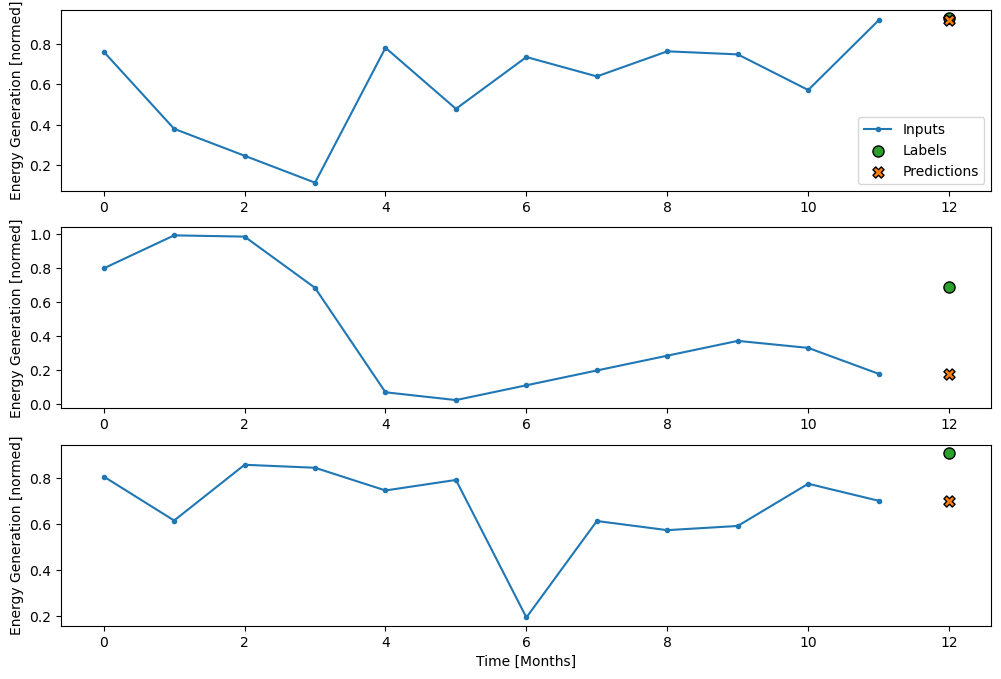

In [7]:
plot(inputs=X_val, labels=Y_val, model=baseline)

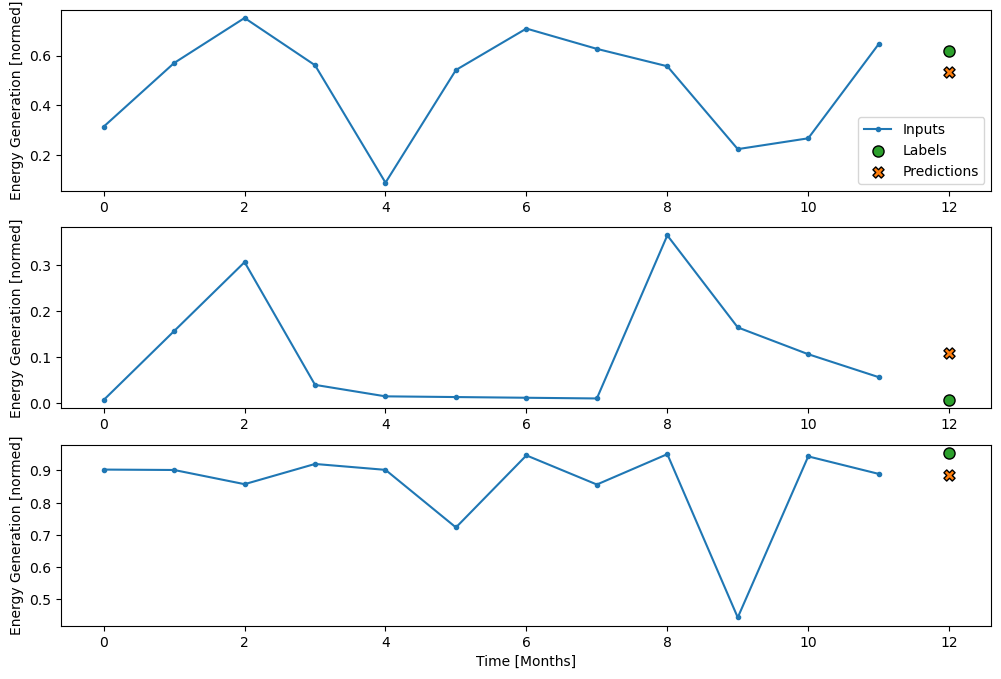

In [8]:
plot(inputs=X_val, labels=Y_val, model=cnn_lstm)

In [9]:
from predicter import PREDICTER
import pandas as pd
data = pd.read_csv("combined.csv")

pred = PREDICTER(data,cnn_lstm,"3-A1ST-1")

prediction = pred.predict([21704,3676,122115,121116,96448,105658,109108,95838,97307,122318,118503,108906])

print(prediction)



[94096.9]


In [6]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
%tensorboard --logdir logs